# Cryptolytic Arbitrage Model Evaluation and Selection

This notebook contains the code and analysis to select models with the best performance for the Cryptolytic project. You can find more information on data processing in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_data_processing.ipynb) and modeling in this [notebook](https://github.com/Cryptolytic-app/cryptolytic/blob/master/modeling/arbitrage_modeling.ipynb).

#### What is arbitrage?
Arbitrage occurs when there is a price difference between the same asset in two different markets. So with crypto, it’s possible to have the same coin priced differently on separate exchanges. For example with bitcoin, you might have bitcoin priced at 8,000 on one exchange, and at the same time that bitcoin can be priced at 8,100 on another exchange. You can buy the bitcoin on the first exchange for 8,000, send it to the other exchange, and sell it for 8,100. Now you’ve made 100 in profit and you can repeat this process as long as that arbitrage opportunity lasts.

#### Background on arbitrage models
There are many different combinations of arbitrage that could be occuring at any given moment among all the cryptocurrency exchanges. Our goal was to capture as many of these as possible in order to create an API that provides predictions for any arbitrage opportunities that will occur in the next 10 minutes. This API could then serve as the backend for a web application that displays the predictions in a more user-friendly format.

The arbitrage models in this notebook predict arbitrage 10 min before it happens, lasting for at least 30 mins. It's important that the arbitrage window lasts long enough because it takes time to move coins from one exchange to the other in order to successfully complete the arbitrage trades. The datasets used for modeling are generated by getting all of the combinations of 2 exchanges that support the same trading pair, engineering technical analysis features, merging that data on 'closing_time', engineering more features, and creating a target that signals an arbitrage opportunity. Arbitrage signals predicted by the models have a direction indicating which direction the arbitrage occurs in.

#### Modeling
There were 11 different types of models trained for each arbitrage combination which will be evaluated in this notebook. Each arbitrage combination model set had 70 models:
- lr_bl: Logistic Regression baseline
- rf_bl: Random Forest baseline
- lr_25_feat: Logistic Regression with top 25 features
- lr_50_feat: Logistic Regression with top 50 features
- lr_70_feat: Logistic Regression with top 75 features
- lr_85_feat: Logistic Regression with top 85 features
- rf_25_feat: Random Forest with top 25 features
- rf_50_feat: Random Forest with top 50 features
- rf_70_feat: Random Forest with top 75 features
- rf_85_feat: Random Forest with top 85 features
- rf_hyper: Random Forest with top 70 features, 60 hyperparameter combinations

Note: the most important features were determined by training the best baseline model `cbpro_bitfinex_ltc_usd` with all of the features and getting the feature importances from scikit learn.


#### Model Evaluation Criteria
After training the models, we exported a [csv](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/data/model_perf.csv) containing all of the performance metrics that could be used to select the best models:
<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/arb-nb/modeling/assets/perf_df.png?raw=true"
     alt="drawing"
     width="1000"/>

Since the training datasets contained imbalanced classes, accuracy score alone would not be a good measure of each model's performance. The additional metrics we used to evaluate the models were:
- Mean Percent Profit: the percent profit for executing arbitrage trades predicted in the test set averaged over all predictions 
- Precison: TP / (TP + FP), broken down by class (-1, 0, 1)
- Recall: TP / (TP + FN), broken down by class (-1, 0, 1) 
- Fall-Out (or FPR): FP / (TN + FP) for 0 class

#### Model Selection
From the 420 iterations of models trained, the models were narrowed down based on the following criteria:
- FPR less than 30% for 0 class
- Precision greater than 70% for 0 class
- Recall greater than 70% for 0 class
- Predicted arbitrage correctly at least 100 times
- Mean percent profit greater than 0.5%

We optimized for making good predictions for the 0 class because we don't want the model making predictions of arbitrage when it doesn't actually exist. That would cause risky trades.

After filtering, we then sorted the models by precision and dropped duplicate models within each model set to get the best 6 models shown below:
<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/top_models.png?raw=true"
     alt="drawing"
     width="1000"/>
        
#### Visualizations
Model performance was visualized in two ways:
- **Portfolio Performance:** shows the change in portfolio value if you started with 10K and traded on all arbitrage predictions made by the model (given that each arbitrage trade has taken the time to fully execute so it simulates a more real world scenario, it will skip over trades that would be impossible to execute). Also plots the baseline model for comparison and takes 0.55% in fees into consideration.
- **Model Predictions**: Visualizes the model's arbitrage predictions (from either exchange 1 to exchange 2 or vice versa) over the percent difference of the cryptocurrency between the two exchanges to show if the model is predicting the appropriate class.

##### **Portfolio Performance Visualization**
Below we can see that the Coinbase Pro/Bitfinex LTC/USD model would have gained 1825% in 211 days if acting on predictions from the best model vs 1732% gain with the baseline model in the same time period.
<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/visualizations/cbpro_bitfinex_ltc_usd_profit.png?raw=true"
     alt="drawing"
     width="1000"/>

##### **Prediction Visualization**
Considering the same Coinbase Pro/Bitfinex LTC/USD model as above, we can see when the model is making predictions of arbitrage from exchange 1 to exchange 2 (purple) or predictions of arbitrage from exchange 2 to exchange 1 (pink). The model does a good job of classifiying the different directions of arbitrage seeing that the pink dots are above the 0% change and purple dots are below the 0% change. You can also see how the profits increase on the above portfolio performance visualization in accordance with the models predictions on the visualization below.
<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/visualizations/cbpro_bitfinex_ltc_usd_preds.png?raw=true"
     alt="drawing"
     width="1000"/>
     
Visualizations for all models can be found at the end of this notebook.

#### Results and Discussion
We trained 420 different logistic regression and random forest models to predict whether arbitrage will occur in 10 mins from the time of prediction and last for at least 30 minutes to give a user enough time to act on trades. The models predicted 3 classes: -1 (arbitrage from exchange 2 to exchange 1), 0 (no arbitrage), and 1 (arbitrage from exchange 1 to exchange 2). Since the training datasets were imbalanced, accuracy score was not the best metric to evaluate models, so we used precision, recall, false positive rate, and mean percent profit to filter and select the best 6 models:
- hitbtc_cbpro_eth_usdc_rf_70_feat_hyper_auto_12_100
- cbpro_bitfinex_ltc_usd_rf_25_feat
- cbpro_bitfinex_eth_usd_rf_70_feat_hyper_50_21_100
- bitfinex_hitbtc_ltc_usdt_rf_70_feat_hyper_auto_12_100
- bitfinex_hitbtc_bch_usdt_rf_70_feat_hyper_auto_12_150
- bitfinex_cbpro_btc_usd_rf_70_feat_hyper_auto_25_100

The final 6 models were all profitable with percent mean profit for each arbitrage trade ranging anywhere from 0.51% to 2.68%. We optimized for precision on the 0 class to ensure that the models were not making arbitrage predictions when arbitrage didn't exist. Random Forest Classifier outperformed Logistic Regression models in this case and precision (0) improved anywhere from 2-22% percent between these best models above and the logistic regression baseline models. The change in model performance metrics between the baseline model and the best performing model, broken down per model is shown below:

<img src="https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/assets/diff_df.png?raw=true" 
     alt="drawing"
     width="1000"/>
     
The final models deployed in the Cryptolytic project can be downloaded in a zip file [here](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/models/arb_pickles.zip).

#### Directory Structure
```
├── cryptolytic/                        <-- Root directory   
│   ├── modeling/                       <-- Directory for modeling work
│   │      │
│   │      ├──assets/                   <-- Directory with png assets used in notebooks
│   │      │
│   │      ├──data/                     <-- Directory containing all data for project
│   │      │   ├─ arb_data/             <-- Directory for train data after merging + FE pt.2
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ arb_preds_test_data/  <-- Directory for test data w/ predictions
│   │      │   │   └── *.csv 
│   │      │   │
│   │      │   ├─ raw_data/             <-- Directory for raw training data
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ ta_data/              <-- Directory for csv files after FE pt.1 
│   │      │   │   └── *.csv
│   │      │   │
│   │      │   ├─ zip_raw_data/         <-- Directory containing zip files of raw data
│   │      │   │   └── *.zip
│   │      │   │
│   │      │   ├─ features.txt          <-- All feature sets used in modeling
│   │      │   │
│   │      │   ├─ model_perf.csv        <-- Data from training baseline models and tuning
│   │      │   │
│   │      │   ├─ top_model_perf.csv    <-- Data from retraining and exporting best models
│   │      │   │
│   │      │   ├─ train_data_paths.txt  <-- Paths to training data that's used in modeling
│   │      │
│   │      ├── models/                  <-- Directory for all pickle models
│   │      │      └── *.zip
│   │      │
│   │      ├─ 1_arbitrage_data_processing.ipynb  <-- NB for data processing and creating csv
│   │      │
│   │      ├─ 2_arbitrage_modeling.ipynb         <-- NB for baseline models and tuning
│   │      │
│   │      ├─ 3_arbitrage_model_evaluation.ipynb <-- NB for model selection, eval, and viz
│   │      │
│   │      ├─ trade_recommender_models.ipynb     <-- NB for trade recommender models
│   │      │
│   │      ├─ environment.yml                    <-- Contains project dependencies
│   │      │
│   │      ├─ utils.py                           <-- All the functions used in modeling
│   │      │

```

## Imports

This project uses conda to manage environments.

In [198]:
# to update your conda env from a yml file from terminal
# conda env update --file modeling/environment.yml

# to export yml from terminal
# conda env export --no-builds > modeling/environment.yml

In [199]:
import ast
import datetime as dt
import glob
import itertools
import json
import os
from pathlib import Path
import pickle
import shutil
import warnings
warnings.filterwarnings("ignore")
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from utils import create_models

## Data

#### Training Data

Load all the arbitrage datasets that will be used in retraining and exporting the best models after they're selected.

In [196]:
with open ('data/train_data_paths.txt', 'rb') as fp:
    train_data_paths = pickle.load(fp)
print(len(train_data_paths)) #6
train_data_paths

6


['data/arb_data/hitbtc_cbpro_eth_usdc.csv',
 'data/arb_data/cbpro_bitfinex_ltc_usd.csv',
 'data/arb_data/bitfinex_hitbtc_bch_usdt.csv',
 'data/arb_data/cbpro_bitfinex_eth_usd.csv',
 'data/arb_data/bitfinex_cbpro_btc_usd.csv',
 'data/arb_data/bitfinex_hitbtc_ltc_usdt.csv']

Each dataset should look like this...

In [197]:
pd.read_csv(train_data_paths[4], index_col=0).head()

,open_exchange_1,high_exchange_1,low_exchange_1,close_exchange_1,base_volume_exchange_1,nan_ohlcv_exchange_1,volume_adi_exchange_1,volume_obv_exchange_1,volume_cmf_exchange_1,volume_fi_exchange_1,volume_em_exchange_1,volume_vpt_exchange_1,volume_nvi_exchange_1,volatility_atr_exchange_1,volatility_bbh_exchange_1,volatility_bbl_exchange_1,volatility_bbm_exchange_1,volatility_bbhi_exchange_1,volatility_bbli_exchange_1,volatility_kcc_exchange_1,volatility_kch_exchange_1,volatility_kcl_exchange_1,volatility_kchi_exchange_1,volatility_kcli_exchange_1,volatility_dch_exchange_1,volatility_dcl_exchange_1,volatility_dchi_exchange_1,volatility_dcli_exchange_1,trend_macd_exchange_1,trend_macd_signal_exchange_1,trend_macd_diff_exchange_1,trend_ema_fast_exchange_1,trend_ema_slow_exchange_1,trend_adx_exchange_1,trend_adx_pos_exchange_1,trend_adx_neg_exchange_1,trend_vortex_ind_pos_exchange_1,trend_vortex_ind_neg_exchange_1,trend_vortex_diff_exchange_1,trend_trix_exchange_1,trend_mass_index_exchange_1,trend_cci_exchange_1,trend_dpo_exchange_1,trend_kst_exchange_1,trend_kst_sig_exchange_1,trend_kst_diff_exchange_1,trend_ichimoku_a_exchange_1,trend_ichimoku_b_exchange_1,trend_visual_ichimoku_a_exchange_1,trend_visual_ichimoku_b_exchange_1,trend_aroon_up_exchange_1,trend_aroon_down_exchange_1,trend_aroon_ind_exchange_1,momentum_rsi_exchange_1,momentum_mfi_exchange_1,momentum_tsi_exchange_1,momentum_uo_exchange_1,momentum_stoch_exchange_1,momentum_stoch_signal_exchange_1,momentum_wr_exchange_1,momentum_ao_exchange_1,momentum_kama_exchange_1,others_dr_exchange_1,others_dlr_exchange_1,others_cr_exchange_1,closing_time,open_exchange_2,high_exchange_2,low_exchange_2,close_exchange_2,base_volume_exchange_2,nan_ohlcv_exchange_2,volume_adi_exchange_2,volume_obv_exchange_2,volume_cmf_exchange_2,volume_fi_exchange_2,volume_em_exchange_2,volume_vpt_exchange_2,volume_nvi_exchange_2,volatility_atr_exchange_2,volatility_bbh_exchange_2,volatility_bbl_exchange_2,volatility_bbm_exchange_2,volatility_bbhi_exchange_2,volatility_bbli_exchange_2,volatility_kcc_exchange_2,volatility_kch_exchange_2,volatility_kcl_exchange_2,volatility_kchi_exchange_2,volatility_kcli_exchange_2,volatility_dch_exchange_2,volatility_dcl_exchange_2,volatility_dchi_exchange_2,volatility_dcli_exchange_2,trend_macd_exchange_2,trend_macd_signal_exchange_2,trend_macd_diff_exchange_2,trend_ema_fast_exchange_2,trend_ema_slow_exchange_2,trend_adx_exchange_2,trend_adx_pos_exchange_2,trend_adx_neg_exchange_2,trend_vortex_ind_pos_exchange_2,trend_vortex_ind_neg_exchange_2,trend_vortex_diff_exchange_2,trend_trix_exchange_2,trend_mass_index_exchange_2,trend_cci_exchange_2,trend_dpo_exchange_2,trend_kst_exchange_2,trend_kst_sig_exchange_2,trend_kst_diff_exchange_2,trend_ichimoku_a_exchange_2,trend_ichimoku_b_exchange_2,trend_visual_ichimoku_a_exchange_2,trend_visual_ichimoku_b_exchange_2,trend_aroon_up_exchange_2,trend_aroon_down_exchange_2,trend_aroon_ind_exchange_2,momentum_rsi_exchange_2,momentum_mfi_exchange_2,momentum_tsi_exchange_2,momentum_uo_exchange_2,momentum_stoch_exchange_2,momentum_stoch_signal_exchange_2,momentum_wr_exchange_2,momentum_ao_exchange_2,momentum_kama_exchange_2,others_dr_exchange_2,others_dlr_exchange_2,others_cr_exchange_2,year,month,day,higher_closing_price,pct_higher,arbitrage_opportunity,window_length,arbitrage_opportunity_shift,window_length_shift,target
0,278.04,278.05,277.99,277.99,9.115813,0.0,-11.656990,-98329.562325,-0.394465,2.499380,-0.000708,-0.005381,4940.888397,0.348091,279.038464,277.217536,278.1280,0.0,0.0,277.835667,278.187667,277.483667,0.0,0.0,278.86,277.51,0.0,0.0,-0.101287,-0.114734,0.013447,277.978647,278.079934,23.306749,23.459737,21.927422,0.814607,1.129213,0.314607,-0.005730,26.310518,-26.737524,-0.2480,-1.559092,-0.843776,-0.715315,278.0875,278.19,277.975,278.21,20.0,64.0,-44.0,48.141113,59.159859,-5.650201,40.157082,36.305732,46.912037,-63.694268,-0.184647,277.885884,-0.017983,-0.017985,-12.045181,2015-07-20 21:40:00,277.98,277.99,277.97,277.97,1.5

#### Model Performance Data

Load the performance data that was exported after model training ([link to csv on GH](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/data/model_perf.csv)). This dataset contains the performance metrics from 420 models to choose from. These models are broken down by:
- 15 arbitrage combinations (csv_name)
    - 7 model_labels:
        - lr_bl: Logistic Regression baseline
        - rf_bl: Random Forest baseline
        - lr_25_feat: Logistic Regression with top 25 features
        - lr_50_feat: Logistic Regression with top 50 features
        - lr_70_feat: Logistic Regression with top 70 features
        - lr_85_feat: Logistic Regression with top 85 features
        - rf_25_feat: Random Forest with top 25 features
        - rf_50_feat: Random Forest with top 50 features
        - rf_70_feat: Random Forest with top 70 features
        - rf_85_feat: Random Forest with top 85 features
        - rf_70_feat_hyper: Random Forest with top 70 features, 60 parameter combinations

In [236]:
perf_df = pd.read_csv('data/model_perf.csv')
print(perf_df.shape) #(420, 20)
perf_df.head()

(420, 20)


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,hitbtc_cbpro_eth_usdc_lr_bl,hitbtc_cbpro_eth_usdc,lr_bl,{},0.777024,1.28,1.24,0.252416,2073,1788,3861,0.852735,0.747584,0.853461,0.703427,0.929688,0.462135,0.770919,0.828750,0.599598
1,cbpro_bitfinex_ltc_usd_lr_bl,cbpro_bitfinex_ltc_usd,lr_bl,{},0.957346,4.51,5.04,0.044642,208,4343,4551,0.722222,0.955358,0.998620,0.525253,0.998402,0.651515,0.608187,0.976406,0.788561
2,bitfinex_hitbtc_bch_usdt_lr_bl,bitfinex_hitbtc_bch_usdt,lr_bl,{},0.789168,1.22,0.83,0.211987,429,1421,1850,0.676656,0.788013,0.836867,0.358696,0.932211,0.585014,0.468852,0.854068,0.688636
3,cbpro_bitfinex_eth_usd_lr_bl,cbpro_bitfinex_eth_usd,lr_bl,{},0.858255,1.51,1.14,0.097918,161,5858,6019,0.851852,0.902082,0.605728,0.358575,0.929062,0.531097,0.504702,0.915374,0.565963
4,bitfinex_cbpro_btc_usd_lr_bl,bitfinex_cbpro_btc_usd,lr_bl,{},0.835886,2.57,2.22,0.195640,14327,324,14651,0.979825,0.804360,0.796069,0.527620,0.992956,0.708972,0.685896,0.888763,0.750000


## Model Selection

We want to narrow down the 420 models to find the best model from each set that fits the following criteria:
- FPR less than 30%
- Precision greater than 70% for 0 class
- Recall greater than 70% for 0 class
- Predicted arbitrage correctly at least 100 times
- Mean percent profit greater than 0.5%

In [237]:
def model_selection(df):
    """
    Filters dataframe of model performance data for models that
    fit certain criteria and returns a dataframe of the best
    models for each arbitrage combination and a dataframe with all 
    of the baseline models for each arbitrage combination including
    the best model and the best hyperparameter tuned model.
    """ 
    # filter for models that meet evaluation criteria
    temp_df = df[df['fpr'] < 0.20]
    temp_df = temp_df[temp_df['precision_0'] > 0.80]
    temp_df = temp_df[temp_df['recall_0'] > 0.70]
    temp_df = temp_df[temp_df['correct_arb_1'] > 50]
    temp_df = temp_df[temp_df['correct_arb_neg1'] > 50]
    temp_df = temp_df[temp_df['pct_profit_mean'] > 0.5]
    
    # sort and drop duplicates to get a top model from each set
    top_models_df = temp_df.sort_values(
        by=['precision_0', 'precision_1', 'precision_neg1'], 
        ascending=False
    )
    top_models_df = top_models_df.drop_duplicates(subset=['csv_name'])
    
    # keep top model + additional models in that set w/ only best hyper
    top_model_sets = temp_df['csv_name'].to_list()
    bl_df = df[df['csv_name'].isin(top_model_sets)]
    # feature to indicate whether the row is the top model from that set
    tm = top_models_df['model_id'].to_list()
    bl_df['top_model'] = [1 if m in tm else 0 for m in bl_df['model_id']]
    # drop extra hyper models 
    bl_df = bl_df.sort_values(
        by=['top_model', 'precision_0', 'precision_1', 'precision_neg1'], 
        ascending=False
    )
    bl_df = bl_df.drop_duplicates(subset=['csv_name', 'model_label'])
    
    return top_models_df, bl_df

In [238]:
top_models_df, bl_df = model_selection(perf_df)

Below are the 6 best models:

In [239]:
top_models_df

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
55,cbpro_bitfinex_ltc_usd_rf_25_feat,cbpro_bitfinex_ltc_usd,rf_25_feat,{},0.961041,2.68,2.40,0.013484,79,6270,6349,0.589552,0.986516,0.796292,0.199495,0.969177,0.940594,0.298113,0.977769,0.862448
222,cbpro_bitfinex_eth_usd_rf_70_feat_hyper_50_21_100,cbpro_bitfinex_eth_usd,rf_70_feat_hyper,"{'max_depth': 21, 'max_features': 50, 'n_estim...",0.964107,2.16,1.32,0.014962,195,10459,10654,0.870536,0.985038,0.872601,0.434298,0.971736,0.948232,0.579495,0.978342,0.908846
350,bitfinex_cbpro_btc_usd_rf_70_feat_hyper_auto_2...,bitfinex_cbpro_btc_usd,rf_70_feat_hyper,"{'max_depth': 25, 'max_features': 'auto', 'n_e...",0.969498,2.06,1.97,0.015597,26714,73,26787,0.942260,0.984403,0.802198,0.983796,0.969159,0.159737,0.962580,0.976721,0.266423
360,bitfinex_hitbtc_ltc_usdt_rf_70_feat_hyper_auto...,bitfinex_hitbtc_ltc_usdt,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.882237,0.51,0.47,0.096234,76,284,360,0.510067,0.903766,0.563492,0.119685,0.969024,0.409222,0.193878,0.935258,0.474124
120,hitbtc_cbpro_eth_usdc_rf_70_feat_hyper_auto_12...,hitbtc_cbpro_eth_usdc,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.815317,0.94,0.74,0.166563,2201,3010,5211,0.806227,0.833437,0.776774,0.746861,0.852143,0.777979,0.775410,0.842687,0.777376
241,bitfinex_hitbtc_bch_usdt_rf_70_feat_hyper_auto...,bitfinex_hitbtc_bch_usdt,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.803386,0.94,0.61,0.175956,621,1655,2276,0.664882,0.824044,0.789599,0.519231,0.893433,0.681350,0.583099,0.857337,0.731492


In [208]:
bl_df = bl_df.sort_values(
    by=['csv_name'], 
    ascending=False
)
print(len(bl_df)) #66 models
bl_df.head()

66


,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1,top_model
6,hitbtc_cbpro_eth_usdc_rf_bl,hitbtc_cbpro_eth_usdc,rf_bl,{},0.720355,0.88,0.71,0.295200,1217,2080,3297,0.766856,0.704800,0.761068,0.412962,0.891926,0.537607,0.536833,0.787398,0.630112,0
18,hitbtc_cbpro_eth_usdc_lr_70_feat,hitbtc_cbpro_eth_usdc,lr_70_feat,{},0.579700,NaN,NaN,0.420300,0,0,0,0.000000,0.579700,0.000000,0.000000,1.000000,0.000000,0.000000,0.733937,0.000000,0
12,hitbtc_cbpro_eth_usdc_lr_85_feat,hitbtc_cbpro_eth_usdc,lr_85_feat,{},0.579700,NaN,NaN,0.420300,0,0,0,0.000000,0.579700,0.000000,0.000000,1.000000,0.000000,0.000000,0.733937,0.000000,0
120,hitbtc_cbpro_eth_usdc_rf_70_feat_hyper_auto_12...,hitbtc_cbpro_eth_usdc,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.815317,0.94,0.74,0.166563,2201,3010,5211,0.806227,0.833437,0.776774,0.746861,0.852143,0.777979,0.775410,0.842687,0.777376,1
24,hitbtc_cbpro_eth_usdc_lr_50_feat,hitbtc_cbpro_eth_usdc,lr_50_feat,{},0.588580,0.84,0.77,0.395418,591,245,836,0.464258,0.604582,0.454545,0.200543,0.926391,0.063324,0.280095,0.731664,0.111162,0


## Comparing Model Sets

We want to quantify the impact of changes made through several iterations of modeling by comparing accuracy, mean percent profit, precision, and recall. More specifically, we are looking at:
- the change from logistic regression baseline to random forest baseline
- the change from adding more features to logistic regression and random forest models
    - 25 features
    - 50 features
    - 70 features
    - 85 features 
- the change from hyperparameter tuning the 70 feature rf model in comparison to the default 70 feature rf model
- the overall change between the best model and the baseline logistic regression model

In [209]:
def get_diffs(df):
    """
    Calculate the performance changes between 11 different model
    sets to see the impact between different modeling algorithms,
    adding technical analyisis features, and hyperparameter tuning.
    
    Parameters
    __________
    df: a dataframe containing all of the performance metrics from the
        models trained for each arbitrage combination ('lr_bl', 'rf_bl',
        'lr_25_feat', lr_50_feat, lr_70_feat, lr_85_feat, 'rf_25_feat',
        rf_50_feat, rf_70_feat, rf_85_feat, 'rf_70_feat_hyper'). Only 
        the best model is included from hyper-parameter tuning.
    
    Return
    ______
    df: the original dataframe with added % change between model types for
        each evaluation metric
    """
    df = df.copy()
    
    model_sets = set(df['csv_name'].to_list())
    labels = set(df['model_label'].to_list())
    metrics = ['accuracy', 'pct_profit_mean', 'precision_neg1', 'precision_0',
               'precision_1', 'recall_neg1', 'recall_0', 'recall_1']
    
    # dict to store comparison metrics for all model sets
    features_dict = {}
    for model_set in model_sets:
        
        # dict to store comparison metrics for one model set
        temp_dict = {}
        
        # dict to store data to calculate comparison metrics for one model set 
        labels_dict = {}
        
        # filter df for specific model set and get row indices
        set_df = df[df['csv_name'] == model_set]
        rows = set_df.index.to_list()
        
        # add data to labels_dict
        for label in labels:
            data = set_df[set_df['model_label'] == label]
            metric_dict = {
                'accuracy': data['accuracy'].values[0],
                'pct_profit_mean': data['pct_profit_mean'].values[0],
                'precision_neg1': data['precision_neg1'].values[0],
                'precision_0': data['precision_0'].values[0],
                'precision_1': data['precision_1'].values[0],
                'recall_neg1': data['recall_neg1'].values[0],
                'recall_0': data['recall_0'].values[0],
                'recall_1': data['recall_1'].values[0],
            }
            labels_dict[label] = metric_dict
        
        for i in rows:
            # dict to store comparison metrics for one model
            comp_dict = {}
            
            # define types of comparisons and which models to compare
            types = {
                'bl': ['lr_bl', 'rf_bl', set_df['model_label'].loc[i] == 'rf_bl'],
                'lr_25_feat': ['lr_bl', 'lr_25_feat', set_df['model_label'].loc[i] == 'lr_25_feat'],
                'lr_50_feat': ['lr_bl', 'lr_50_feat', set_df['model_label'].loc[i] == 'lr_50_feat'],
                'lr_70_feat': ['lr_bl', 'lr_70_feat', set_df['model_label'].loc[i] == 'lr_70_feat'],
                'lr_85_feat': ['lr_bl', 'lr_85_feat', set_df['model_label'].loc[i] == 'lr_85_feat'],
                'rf_25_feat': ['rf_bl', 'rf_25_feat', set_df['model_label'].loc[i] == 'rf_25_feat'],
                'rf_50_feat': ['rf_bl', 'rf_50_feat', set_df['model_label'].loc[i] == 'rf_50_feat'],
                'rf_70_feat': ['rf_bl', 'rf_70_feat', set_df['model_label'].loc[i] == 'rf_70_feat'],
                'rf_85_feat': ['rf_bl', 'rf_85_feat', set_df['model_label'].loc[i] == 'rf_85_feat'],
                'hyper': ['rf_70_feat', 'rf_70_feat_hyper', 
                          set_df['model_label'].loc[i] == 'rf_70_feat_hyper'],
                'bl_top': ['lr_bl', set_df['model_label'].loc[i], set_df['top_model'].loc[i] == 1]
            }
            
            # calculate and store comparison metrics in temp dict
            for t in types:
                for metric in metrics:
                    comp_dict[f'{t}_{metric}_diff'] = (
                        ( labels_dict[types[t][1]][metric] 
                         - labels_dict[types[t][0]][metric] )
                         / np.abs(labels_dict[types[t][0]][metric]) if types[t][2] else np.nan
                    )
            temp_dict[i] = comp_dict
        
        # append the comparison metrics after one model set is complete
        features_dict = {**features_dict, **temp_dict}
    
    # append final results to original df
    feat_df = pd.DataFrame(features_dict).transpose()
    df = pd.merge(df, feat_df, left_index=True, right_index=True)
        
    return df

When we run this function we get a dataframe that now includes columns that compares the metrics of the different types of models we trained.

In [210]:
diff_df = get_diffs(bl_df)
diff_df.head()

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1,top_model,bl_accuracy_diff,bl_pct_profit_mean_diff,bl_precision_neg1_diff,bl_precision_0_diff,bl_precision_1_diff,bl_recall_neg1_diff,bl_recall_0_diff,bl_recall_1_diff,lr_25_feat_accuracy_diff,lr_25_feat_pct_profit_mean_diff,lr_25_feat_precision_neg1_diff,lr_25_feat_precision_0_diff,lr_25_feat_precision_1_diff,lr_25_feat_recall_neg1_diff,lr_25_feat_recall_0_diff,lr_25_feat_recall_1_diff,lr_50_feat_accuracy_diff,lr_50_feat_pct_profit_mean_diff,lr_50_feat_precision_neg1_diff,lr_50_feat_precision_0_diff,lr_50_feat_precision_1_diff,lr_50_feat_recall_neg1_diff,lr_50_feat_recall_0_diff,lr_50_feat_recall_1_diff,lr_70_feat_accuracy_diff,lr_70_feat_pct_profit_mean_diff,lr_70_feat_precision_neg1_diff,lr_70_feat_precision_0_diff,lr_70_feat_precision_1_diff,lr_70_feat_recall_neg1_diff,lr_70_feat_recall_0_diff,lr_70_feat_recall_1_diff,lr_85_feat_accuracy_diff,lr_85_feat_pct_profit_mean_diff,lr_85_feat_precision_neg1_diff,lr_85_feat_precision_0_diff,lr_85_feat_precision_1_diff,lr_85_feat_recall_neg1_diff,lr_85_feat_recall_0_diff,lr_85_feat_recall_1_diff,rf_25_feat_accuracy_diff,rf_25_feat_pct_profit_mean_diff,rf_25_feat_precision_neg1_diff,rf_25_feat_precision_0_diff,rf_25_feat_precision_1_diff,rf_25_feat_recall_neg1_diff,rf_25_feat_recall_0_diff,rf_25_feat_recall_1_diff,rf_50_feat_accuracy_diff,rf_50_feat_pct_profit_mean_diff,rf_50_feat_precision_neg1_diff,rf_50_feat_precision_0_diff,rf_50_feat_precision_1_diff,rf_50_feat_recall_neg1_diff,rf_50_feat_recall_0_diff,rf_50_feat_recall_1_diff,rf_70_feat_accuracy_diff,rf_70_feat_pct_profit_mean_diff,rf_70_feat_precision_neg1_diff,rf_70_feat_precision_0_diff,rf_70_feat_precision_1_diff,rf_70_feat_recall_neg1_diff,rf_70_feat_recall_0_diff,rf_70_feat_recall_1_diff,rf_85_feat_accuracy_diff,rf_85_feat_pct_profit_mean_diff,rf_85_feat_precision_neg1_diff,rf_85_feat_precision_0_diff,rf_85_feat_precision_1_diff,rf_85_feat_recall_neg1_diff,rf_85_feat_recall_0_diff,rf_85_feat_recall_1_diff,hyper_accuracy_diff,hyper_pct_profit_mean_diff,hyper_precision_neg1_diff,hyper_precision_0_diff,hyper_precision_1_diff,hyper_recall_neg1_diff,hyper_recall_0_diff,hyper_recall_1_diff,bl_top_accuracy_diff,bl_top_pct_profit_mean_diff,bl_top_precision_neg1_diff,bl_top_precision_0_diff,bl_top_precision_1_diff,bl_top_recall_neg1_diff,bl_top_recall_0_diff,bl_top_recall_1_diff
6,hitbtc_cbpro_eth_usdc_rf_bl,hitbtc_cbpro_eth_usdc,rf_bl,{},0.720355,0.88,0.71,0.295200,1217,2080,3297,0.766856,0.704800,0.761068,0.412962,0.891926,0.537607,0.536833,0.787398,0.630112,0,-0.072931,-0.3125,-0.100711,-0.05723,-0.108256,-0.412928,-0.040618,0.163311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,hitbtc_cbpro_eth_usdc_lr_70_feat,hitbtc_cbpro_eth_usdc,lr_70_feat,{},0.579700,NaN,NaN,0.420300,0,0,0,0.000000,0.579700,0.000000,0.000000,1.000000,0.000000,0.000000,0.733937,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253948,NaN,-1.0,-0.224568,-1.0,-1.0,0.075629,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,hitbtc_cbpro_eth_usdc_lr_85_feat,hitbtc_cbpro_eth_usdc,lr_85_feat,{},0.579700,NaN,NaN,0.420300,0,0,0,0.000000,0.579700,0.000000,0.000000,1.000000,0.000000,0.000000,0.733937,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.253948,N

#### Comparing baseline models: Logistic Regression vs. Random Forest 

Taking the percent difference between each of the performance metrics for all of the models and then getting the mean for each column, we can see how random forest performs against logistic regression for each metric, on average. In this case, random forest performs worse across the board which is why we see a negative values for most of the metrics. The random forest baseline only performs better than logistic regression with recall for the -1 and 1 classes.

In [211]:
diffs = ['bl']
for d in diffs:
    print('Logistic Regression baseline vs. Random Forest baseline \n')
    columns = [f'{d}_accuracy_diff', f'{d}_pct_profit_mean_diff', f'{d}_precision_neg1_diff',
                    f'{d}_precision_0_diff', f'{d}_precision_1_diff', f'{d}_recall_neg1_diff', 
                    f'{d}_recall_0_diff', f'{d}_recall_1_diff']
    print(diff_df[columns].mean())

Logistic Regression baseline vs. Random Forest baseline 

bl_accuracy_diff          -0.017377
bl_pct_profit_mean_diff   -0.235762
bl_precision_neg1_diff    -0.037516
bl_precision_0_diff        0.017110
bl_precision_1_diff       -0.099023
bl_recall_neg1_diff        7.547976
bl_recall_0_diff          -0.032301
bl_recall_1_diff           1.236709
dtype: float64


#### Difference in adding features: Logistic Regression baseline vs. Logistic Regression with added features (25, 50, 70, 85)

When adding more features, the logistic regression models perform much worse across the board in comparison to the baseline models. All metrics that we compared have a mean negative change.

In [212]:
diffs = ['lr_25_feat', 'lr_50_feat', 'lr_70_feat', 'lr_85_feat']
for d in diffs:
    print(f'\nLR baseline vs. {d}')
    columns = [f'{d}_accuracy_diff', f'{d}_pct_profit_mean_diff', f'{d}_precision_neg1_diff',
                    f'{d}_precision_0_diff', f'{d}_precision_1_diff', f'{d}_recall_neg1_diff', 
                    f'{d}_recall_0_diff', f'{d}_recall_1_diff']
    print(diff_df[columns].mean())


LR baseline vs. lr_25_feat
lr_25_feat_accuracy_diff          -0.189825
lr_25_feat_pct_profit_mean_diff   -0.609254
lr_25_feat_precision_neg1_diff    -0.773085
lr_25_feat_precision_0_diff       -0.070749
lr_25_feat_precision_1_diff       -0.624861
lr_25_feat_recall_neg1_diff       -0.666550
lr_25_feat_recall_0_diff          -0.154568
lr_25_feat_recall_1_diff          -0.656419
dtype: float64

LR baseline vs. lr_50_feat
lr_50_feat_accuracy_diff          -0.211738
lr_50_feat_pct_profit_mean_diff   -0.504817
lr_50_feat_precision_neg1_diff    -0.718256
lr_50_feat_precision_0_diff       -0.088492
lr_50_feat_precision_1_diff       -0.616914
lr_50_feat_recall_neg1_diff       -0.694723
lr_50_feat_recall_0_diff          -0.181369
lr_50_feat_recall_1_diff          -0.654327
dtype: float64

LR baseline vs. lr_70_feat
lr_70_feat_accuracy_diff          -0.320067
lr_70_feat_pct_profit_mean_diff   -0.778108
lr_70_feat_precision_neg1_diff    -0.833507
lr_70_feat_precision_0_diff       -0.248706
lr_70_

#### Difference in adding features: Random Forest baseline vs. Random Forest with added features (25, 50, 70, 85)

When adding more features, the random forest models perform better than the baseline models. Most of the metrics that we compared have a mean postive change. The best feature set was the one with top 70 features.

In [213]:
diffs = ['rf_25_feat', 'rf_50_feat', 'rf_70_feat', 'rf_85_feat']
for d in diffs:
    print(f'\nRF baseline vs. {d}')
    columns = [f'{d}_accuracy_diff', f'{d}_pct_profit_mean_diff', f'{d}_precision_neg1_diff',
                    f'{d}_precision_0_diff', f'{d}_precision_1_diff', f'{d}_recall_neg1_diff', 
                    f'{d}_recall_0_diff', f'{d}_recall_1_diff']
    print(diff_df[columns].mean())


RF baseline vs. rf_25_feat
rf_25_feat_accuracy_diff           0.038806
rf_25_feat_pct_profit_mean_diff    3.373897
rf_25_feat_precision_neg1_diff    -0.036487
rf_25_feat_precision_0_diff        0.010937
rf_25_feat_precision_1_diff        0.281552
rf_25_feat_recall_neg1_diff       -0.422989
rf_25_feat_recall_0_diff           0.034928
rf_25_feat_recall_1_diff           0.611271
dtype: float64

RF baseline vs. rf_50_feat
rf_50_feat_accuracy_diff           0.048956
rf_50_feat_pct_profit_mean_diff    3.572530
rf_50_feat_precision_neg1_diff     0.046350
rf_50_feat_precision_0_diff        0.024373
rf_50_feat_precision_1_diff        0.276219
rf_50_feat_recall_neg1_diff       -0.409301
rf_50_feat_recall_0_diff           0.028841
rf_50_feat_recall_1_diff           0.980458
dtype: float64

RF baseline vs. rf_70_feat
rf_70_feat_accuracy_diff           0.057306
rf_70_feat_pct_profit_mean_diff    3.932720
rf_70_feat_precision_neg1_diff     0.016651
rf_70_feat_precision_0_diff        0.029211
rf_70_

#### Difference in hyperparameter tuning: Random Forest 70 features vs. Random Forest with 70 features and hyperparameter tuning

Hyperparameter tuning worked for some models but not for others so we see mixed results when we look at the changes in the random forest 70 feature models before and after hyperparameter tuning.

In [215]:
diffs = ['hyper']
for d in diffs:
    print(f'\nRF 70 feat vs. RF {d}')
    columns = [f'{d}_accuracy_diff', f'{d}_pct_profit_mean_diff', f'{d}_precision_neg1_diff',
                    f'{d}_precision_0_diff', f'{d}_precision_1_diff', f'{d}_recall_neg1_diff', 
                    f'{d}_recall_0_diff', f'{d}_recall_1_diff']
    print(diff_df[columns].mean())


RF 70 feat vs. RF hyper
hyper_accuracy_diff           0.012958
hyper_pct_profit_mean_diff   -0.080958
hyper_precision_neg1_diff    -0.024622
hyper_precision_0_diff        0.046347
hyper_precision_1_diff       -0.072314
hyper_recall_neg1_diff        1.096510
hyper_recall_0_diff          -0.035563
hyper_recall_1_diff           0.174925
dtype: float64


#### Comparing baseline Logistic Regression with the best model

When we compare the best models to our baseline logistic regression models, we can see that accuracy, precision (0), recall (-1), and recall (1) improved at the expense of pct_mean_profit, precision (-1), precision (1), and recall (0).

In [255]:
diffs = ['bl_top']
for d in diffs:
    columns = ['model_id', 'csv_name', 'model_label', f'{d}_accuracy_diff', f'{d}_pct_profit_mean_diff',
               f'{d}_precision_neg1_diff', f'{d}_precision_0_diff', f'{d}_precision_1_diff', 
               f'{d}_recall_neg1_diff', f'{d}_recall_0_diff', f'{d}_recall_1_diff']
diff_df[diff_df['top_model'] == 1][columns]

,model_id,csv_name,model_label,bl_top_accuracy_diff,bl_top_pct_profit_mean_diff,bl_top_precision_neg1_diff,bl_top_precision_0_diff,bl_top_precision_1_diff,bl_top_recall_neg1_diff,bl_top_recall_0_diff,bl_top_recall_1_diff
120,hitbtc_cbpro_eth_usdc_rf_70_feat_hyper_auto_12...,hitbtc_cbpro_eth_usdc,rf_70_feat_hyper,0.049282,-0.265625,-0.054540,0.114842,-0.089854,0.061746,-0.083410,0.683445
55,cbpro_bitfinex_ltc_usd_rf_25_feat,cbpro_bitfinex_ltc_usd,rf_25_feat,0.003860,-0.405765,-0.183697,0.032613,-0.202608,-0.620192,-0.029272,0.443703
222,cbpro_bitfinex_eth_usd_rf_70_feat_hyper_50_21_100,cbpro_bitfinex_eth_usd,rf_70_feat_hyper,0.123333,0.430464,0.021933,0.091960,0.440582,0.211180,0.045932,0.785422
360,bitfinex_hitbtc_ltc_usdt_rf_70_feat_hyper_auto...,bitfinex_hitbtc_ltc_usdt,rf_70_feat_hyper,0.006617,-0.504854,0.275168,0.027289,0.033069,37.000000,-0.025982,4.259259
241,bitfinex_hitbtc_bch_usdt_rf_70_feat_hyper_auto...,bitfinex_hitbtc_bch_usdt,rf_70_feat_hyper,0.018016,-0.229508,-0.017400,0.045724,-0.056482,0.447552,-0.041597,0.164673
350,bitfinex_cbpro_btc_usd_rf_70_feat_hyper_auto_2...,bitfinex_cbpro_btc_usd,rf_70_feat_hyper,0.159844,-0.198444,-0.038339,0.223835,0.007699,0.864591,-0.023966,-0.774691


## Retrain and Export Best Models

After choosing the best models, we need to train and export the model so they can be used in our project to make predictions on live data. We also need to export the model's predictions in a csv so we can visualize the model's performance.

In [218]:
def train_best_models(df, feature_sets):
    """
    Takes a dataframe of the top models and retrains and exports
    the top model for each arbitrage combination. Exports y_test csv with 
    predictions from the top model and additional y_test csvs with
    predictions from the baseline logistic regression and random forest models. 
    """
    # top models to train
    top_models = df['model_id'].to_list()
    
    for model_id in top_models:
        print(f'\n{model_id}')
        filename = df[df['model_id'] == model_id]['csv_name'].values[0]
        filepath = f'data/arb_data/{filename}.csv'
        model_label = df[df['model_id'] == model_id]['model_label'].values[0]
        params = df[df['model_id'] == model_id]['params'].values[0]
        params = ast.literal_eval(params)
        print('model_label:', model_label)
        print('params:', params)
        
        # params are not in the right format when pulling from df
        # so need to change to a dict with iterable keys
        if params:
            for key in params:
                if isinstance(params[key], list):
                    params[key] = params[key]
                else:
                    params[key] = [params[key]]

        # model type and features
        if model_label.split('_')[0] == 'lr':
            key = model_label.replace('lr_', '')
            features = {str(key): feature_sets[key]}
            model = LogisticRegression(
                solver='lbfgs', 
                multi_class='multinomial',
                random_state=42
            )
        else: # rf models
            key = model_label.replace('rf_', '')
            features = {str(key): feature_sets[key.replace('_hyper', '')]}
            model = RandomForestClassifier(
                n_jobs=-1,
                random_state=42
            )
        
        # train and export top model
        create_models(
            train_data_paths=[filepath],
            model_type=model,
            features=features,
            param_grid=params,
            filename='data/top_model_perf.csv',
            export_preds=True,
            export_model=True
        )
        
        # train and export rf bl model
        if model_label != 'rf_bl':
            create_models(
                train_data_paths=[filepath],
                model_type=RandomForestClassifier(
                    n_jobs=-1, 
                    random_state=42
                ),
                features={'bl': feature_sets['bl']},
                param_grid={},
                filename='data/top_model_perf.csv',
                export_preds=True,
                export_model=False
            )
        
        # train and export lr bl model
        if model_label != 'lr_bl':
            create_models(
                train_data_paths=[filepath],
                model_type=LogisticRegression(
                    solver='lbfgs', 
                    multi_class='multinomial'
                ),
                features={'bl': feature_sets['bl']},
                param_grid={},
                filename='data/top_model_perf.csv',
                export_preds=True,
                export_model=False
            )

#### Load Features from JSON file

Feature sets were determined in the arbitrage modeling notebook and the txt file be found [here](https://github.com/Cryptolytic-app/cryptolyticapp/blob/master/modeling/data/features.txt).

In [219]:
with open('data/features.txt') as json_file:
    feature_sets = json.load(json_file)
feature_sets.keys()

dict_keys(['bl', 'all', '85_feat', '70_feat', '50_feat', '25_feat'])

#### Train and Export Models

In [220]:
train_best_models(top_models_df, feature_sets)


cbpro_bitfinex_ltc_usd_rf_25_feat
model_label: rf_25_feat
params: {}


 -------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_ltc_usd 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (273337, 141) (60885, 141)
            model id exists:cbpro_bitfinex_ltc_usd_rf_25_feat


 -------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_ltc_usd 
 --------------------------------------------------------------------------------------------------------
             train and test shape:  (273337, 141) (60885, 141)
            model id exists:cbpro_bitfinex_ltc_usd_rf_bl


 -------------------------------------------------------------------------------------------------------- 

 Model 1/1: cbpro_bitfinex_ltc_usd 
 ----------------------------------

In [222]:
top_model_perf_df = pd.read_csv('data/top_model_perf.csv')
top_model_perf_df.head()

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
0,cbpro_bitfinex_ltc_usd_rf_25_feat,cbpro_bitfinex_ltc_usd,rf_25_feat,{},0.961041,2.68,2.40,0.013484,79,6270,6349,0.589552,0.986516,0.796292,0.199495,0.969177,0.940594,0.298113,0.977769,0.862448
1,cbpro_bitfinex_ltc_usd_rf_bl,cbpro_bitfinex_ltc_usd,rf_bl,{},0.957855,4.09,4.81,0.041062,226,4543,4769,0.610811,0.958938,0.972389,0.570707,0.994928,0.681518,0.590078,0.976602,0.801376
2,cbpro_bitfinex_ltc_usd_lr_bl,cbpro_bitfinex_ltc_usd,lr_bl,{},0.957346,4.51,5.04,0.044642,208,4343,4551,0.722222,0.955358,0.998620,0.525253,0.998402,0.651515,0.608187,0.976406,0.788561
3,cbpro_bitfinex_eth_usd_rf_70_feat_hyper_50_21_100,cbpro_bitfinex_eth_usd,rf_70_feat_hyper,"{'max_depth': 21, 'max_features': 50, 'n_estim...",0.969776,2.22,1.35,0.014215,255,10461,10716,0.870307,0.985785,0.898480,0.567929,0.977462,0.948413,0.687332,0.981606,0.922772
4,cbpro_bitfinex_eth_usd_rf_bl,cbpro_bitfinex_eth_usd,rf_bl,{},0.959991,2.73,1.58,0.040453,279,8933,9212,0.815789,0.959547,0.968032,0.621381,0.993387,0.809882,0.705436,0.976174,0.881923


## Visualizations

#### Function to get data

In [228]:
def get_viz_data(csv_name, df):
    """
    Retrieves csvs from top and baseline models and returns them
    as a dataframe.
    """
    # data
    idx = df[df['csv_name'] == csv_name].index[0]
    model_label = df['model_label'].loc[idx]
    bl_label = 'lr_bl'
    base = 'data/arb_preds_test_data'
    csv_path = glob.glob(f'{base}/{csv_name}_{model_label}*.csv')[0]
    bl_csv_path = glob.glob(f'{base}/{csv_name}_{bl_label}.csv')[0]
    
    # dfs 
    preds_df = pd.read_csv(csv_path)
    bl_preds_df = pd.read_csv(bl_csv_path)

    return preds_df, bl_preds_df

#### Feature engineering function for profit visualization

In [229]:
def fe_performance(df, money):
    
    """
    Engineers features for creating a visualization that simulates
    a trading portfolio based on predictions from arbitrage models
    
    Parameters
    __________
    
    df: prediction dataframe to feature engineer
    money: amount of money(number) to simulate an investment
        
    Returns
    _______
    
    df: original dataframe with new columns:
        - perc_diff
        - trade
        - my_money
        - buy
        - sell
    perc_gain: the percentage gain on the portfolio over the trading 
        time period
    days: number of days in the test set
    """
    # create a column with 0 float, empty list, index number
    df['perc_diff'] = 0.0
    trade = []
    i = 0
    
    predict = df['y_preds'].tolist()
    
    # while loop to append trade execution (1-buy, -1-sell)
    # filling in values for perc_diff(% price diff between exchanges)
    while i < (len(predict) - 10):
        if predict[i] == -1:
            trade.extend([0, 0, 1, 0, 0, 0, 0, 0, 0,-1, 0, 0])
            ex2 = df['close_exchange_2'][i+2]
            # calculate percent diff and remove 0.55% in fees
            df['perc_diff'][i+10] = (((
                df['close_exchange_1'][i+10] - ex2)/ex2) - 0.0055
            )
            i += 12
        elif predict[i] == 1:
            trade.extend([0, 0, 1, 0, 0, 0, 0, 0, 0,-1, 0, 0])
            ex1 = df['close_exchange_1'][i+2]
            # calculate percent diff and remove 0.55% in fees
            df['perc_diff'][i+10] = (((
                df['close_exchange_2'][i+10] - ex1)/ex1) - 0.0055
            )
            i += 12
        else: # 0 pred
            trade.append(predict[i])
            i += 1
    
    # take out the last 10 columns because it takes 10 rows to fully 
    # execute a trade and so the last 10 rows will have incomplete data
    df = df[:-10]
    df['trade'] = trade[:len(df)]
       
    # create a column to simulate a user input money amount and making 
    # trades on the predictions
    df['my_money'] = df['perc_diff'].cumsum() * money
    df['my_money'] = df['my_money'] + money

    # create buy/sell columns to plot on visualization
    df['buy'] = df['trade'].apply(lambda x: 1 if x == 1 else 0)
    # shifted by 1 to display better on visual
    df['sell'] = df['trade'].apply(lambda x: 1 if x == -1 else 0).shift(1)
    df['buy'] = (df['buy'] * df['my_money'])
    df['sell'] = (df['sell'] * df['my_money'])
    
    # get total portfolio percent change from start to end
    perc_gain = round(((
        df['my_money'].iloc[-1] - df['my_money'].iloc[0]) /
        df['my_money'].iloc[0]) * 100, 2
    )
    
    # closing time to datetime to display dates on x-axis
    df['closing_time'] = pd.to_datetime(df['closing_time'])
    # get total amount of days in datasets 
    days = (df['closing_time'].iloc[-1] - df['closing_time'].iloc[0]).days

    return df, perc_gain, days

#### Feature engineering function for prediction visualization

In [230]:
def fe_exchange_diff(df):
    """
    Engineers features for creating a visualization that plots
    predictions on a line of percent price difference between exchanges
    """
    df['perc_diff'] = 0.0
    df['pct_diff'] = (
        (df['close_exchange_1'] - df['close_exchange_2']) 
        / df['close_exchange_1']
    )

    # creating separate columns for each target class
    df['arb_ex1_ex2'] = df['y_preds'].apply(lambda x: 1 if x == 1 else np.NaN)
    df['arb_ex2_ex1'] = df['y_preds'].apply(lambda x: 1 if x == -1 else np.NaN)
    df['arb_ex1_ex2'] = (df['arb_ex1_ex2'] * df['pct_diff'])
    df['arb_ex2_ex1'] = (df['arb_ex2_ex1'] * df['pct_diff'])
    
    # closing time to datetime to display dates on x-axis
    df['closing_time'] = pd.to_datetime(df['closing_time'])
    
    return df

#### Function for profit visualization

In [248]:
def arb_profit_viz(csv_name, df, money):
    """
    Creates a visualization that simulates trading with predictions 
    from top and baseline models.
    
    Parameters
    ___________
    
    csv_name: name of an arb csv (string)
        ex. 'bitfinex_cbpro_etc_usd'
    df: dataframe with the best performing models 
    money: dollar amount to simulate a trading portfolio (int)
    """
    preds_df, bl_preds_df = get_viz_data(csv_name, df)
    preds_df, perc_gain, days = fe_performance(preds_df, money)
    bl_preds_df, bl_perc_gain, bl_days = fe_performance(bl_preds_df, money)
    
    model_id = df[df['csv_name'] == csv_name]['model_id'].values[0]
    bl_model_id = f'{csv_name}_lr_bl'

    # creating figure and setting size
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.clf()
    sns.set(style="ticks", context="talk")
    
    # setting dark background
    plt.style.use("dark_background")

    # using these color palette 
    flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5',
              '#57d5c7', '#5dddb9', '#63e4a7']
    
    # seperate df into 6 
    len_6 = (len(preds_df)//6)

    # Best Model lineplot
    # create 6 lineplots to create a gradient look 
    sns.set_palette(flatui)
    ax = sns.lineplot(
        x='closing_time', 
        y='my_money',
        data=preds_df[:len_6]
    )

    for i in range(1, 6):
        sns.set_palette(flatui)
        if i != 3:
            ax = sns.lineplot(
                x='closing_time', 
                y='my_money',
                data=preds_df[(len_6*i):(len_6*(i+1))]
            )
        else:
            ax = sns.lineplot(
                x='closing_time', 
                y='my_money',
                data=preds_df[(len_6*i):(len_6*(i+1))],
                label=f'Best Model\n{perc_gain}% gain in {days} days'
            )
            
    ### baseline lineplot
    if model_id != bl_model_id:
        # create 6 lineplots to create a gradient look
        sns.set_palette(flatui)
        ax = sns.lineplot(
            x='closing_time', 
            y='my_money',
            linewidth = .6,
            data=bl_preds_df[:len_6]
        )

        for i in range(1, 6):
            sns.set_palette(flatui)
            if i != 3:
                ax = sns.lineplot(
                    x='closing_time', 
                    y='my_money',
                    linewidth = .6,
                    data=bl_preds_df[(len_6*i):(len_6*(i+1))]
                )
            else:
                ax = sns.lineplot(
                    x='closing_time', 
                    y='my_money',
                    linewidth = .6,
                    data=bl_preds_df[(len_6*i):(len_6*(i+1))],
                    label=f'Baseline Model\n{bl_perc_gain}% gain ' \
                          f' in {bl_days} days'
                )
                
    # despine all sides, except the bottom
    sns.despine(left=True, right=True, top=True)

    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value')
    
    # setting y_limit for this model
    l_ylim = min(preds_df['my_money']) - 10000
    h_ylim = max(preds_df['my_money']) + 10000
    plt.ylim(l_ylim, h_ylim)
    
    # setting y tick labels 
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:,.0f}'.format(x) for x in vals])

    # get rid of '-' on tick label
    ax.tick_params(axis=u'both', which=u'both', length=0)

    # change x and y tick color grey
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # set bottom spine grey and change linewidth
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)

    # change font style 
    for tick in ax.get_xticklabels():
        tick.set_fontname('DejaVu Sans')
    for tick in ax.get_yticklabels():
        tick.set_fontname('DejaVu Sans')

    # format datetime for x-axis tick label
    myFmt = mdates.DateFormatter('%b. %d    ')
    ax.xaxis.set_major_formatter(myFmt)
    
    # rotate x-tick labels at a 45 degree angle
    plt.setp(ax.get_xticklabels(), rotation=45)
    
    
    # to get labels from both axes and return them into one legend
    lines, labels = ax.get_legend_handles_labels()

    # plot legend 
    leg = plt.legend(lines, labels, loc='lower right')

    # get rid of legend frame 
    leg.get_frame().set_linewidth(0.0)

    # set titles
    ax.set_title(
        f'Trading Performance with a ${money} Portfolio\n{model_id}', 
        fontsize=25
    ).set_position([.5, 1.06])
    
    fig.tight_layout(rect=[-.1,-.1,1,1]) 
    
    ax.yaxis.set_label_coords(-0.07,.5)
    ax.xaxis.set_label_coords(.5,-0.15)
    
    plt.show()
    
    # save figure in png
    fig.savefig(
        f'assets/visualizations/{csv_name}_profit.png', 
        bbox_inches='tight'
    )

#### Function for prediction visualization

In [249]:
def arb_pred_viz(csv_name, df):
    """
    Visualize different classes of arbitrage predictions from a model
    over a line of price percentage difference between exchanges
    
    Parameters
    ___________
    
    csv_name: a string name of a arb csv 
        ex. 'bitfinex_cbpro_etc_usd'
    df: dataframe with best models 
    """
    preds_df, bl_preds_df = get_viz_data(csv_name, df)
    preds_df = fe_exchange_diff(preds_df)
    
    # creating figure and setting size
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.clf()
    sns.set(style="ticks", context="talk")

    # setting dark background
    plt.style.use("dark_background")

    # using these color palette 
    flatui = ['#4eb9ff', '#4bc1f6', '#4fc9e5',
              '#57d5c7', '#5dddb9', '#63e4a7']
    
    # seperate df into 6 
    len_6 = (len(preds_df)//6)

    # create 6 lineplots to create a gradient look 
    sns.set_palette(flatui)
    ax = sns.lineplot(
        x='closing_time', 
        y='pct_diff',
        linewidth = .4,
        data=preds_df[:len_6]
    )

    for i in range(1, 6):
        sns.set_palette(flatui)
        if i != 3:
            ax = sns.lineplot(
                x='closing_time', 
                y='pct_diff',
                data=preds_df[len_6*i:len_6*(i+1)],
                linewidth = .4
            )
        else:
            ax = sns.lineplot(
                x='closing_time', 
                y='pct_diff',
                data=preds_df[len_6*i:len_6*(i+1)],
                linewidth = .4,
                label='Percentage Price Difference'
            )

    # creating 2 scatter plots with new df
    scatter_1 = sns.scatterplot(
        x='closing_time', 
        y='pct_diff',
        data=preds_df[preds_df['y_preds'] == 1], 
        color='indigo',
        zorder=10, 
        alpha=0.5, 
        linewidth=0.1,
        label='Arbitrage from Exchange 1 to 2')
    scatter_neg1 = sns.scatterplot(
        x='closing_time', 
        y='pct_diff',
        data=preds_df[preds_df['y_preds'] == -1], 
        color='violet',
        zorder=10, 
        alpha=0.5, 
        linewidth=0.1,
        label='Arbitrage from Exchange 2 to 1')

    sns.despine(left=True, right=True, top=True)

    ax.set_xlabel('Date')
    ax.set_ylabel('Percent Difference')

    # setting y tick labels 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    ax.set_xticklabels('')

    # get rid of '-' on tick label
    ax.tick_params(axis=u'both', which=u'both',length=0)

    # change x and y tick color grey
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    # set bottom spine grey and change linewidth
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(0.5)

    # change font style 
    for tick in ax.get_xticklabels():
        tick.set_fontname("DejaVu Sans")
    for tick in ax.get_yticklabels():
        tick.set_fontname("DejaVu Sans")

    # format datetime for x-axis tick label
    myFmt = mdates.DateFormatter("%b. %d    ")
    ax.xaxis.set_major_formatter(myFmt)

    # rotate x-tick labels at a 45 degree angle
    plt.setp(ax.get_xticklabels(), rotation=45)

    # creates Legend 
    lines, labels = ax.get_legend_handles_labels()
    leg = plt.legend(lines, labels)
    leg.get_frame().set_linewidth(0.0)
    
    # set titles
    model_id = df[df['csv_name'] == csv_name]['model_id'].values[0]
    ax.set_title(f'Model Predictions: {model_id}', 
                 fontsize=25).set_position([.5, 1.06])
    
    fig.tight_layout(rect=[-.1,-.1,1,1])
    
    ax.yaxis.set_label_coords(-0.07,.5)
    ax.xaxis.set_label_coords(.5,-0.15)
    
    plt.show()
    
    # save figure in png
    fig.savefig(
        f'assets/visualizations/{csv_name}_preds.png', 
        bbox_inches='tight')

#### Function to run profit + pred viz for all models

In [250]:
def create_all_viz(top_models_df):
    """
    Iterates through a dataframe of the top models and creates
    2 visualizations for each model:
    - visualizes simulated trading portfolio
    - visualizes model's predictions
    """
    csv_names = top_models_df['csv_name'].to_list()
    for csv_name in csv_names:
        arb_profit_viz(csv_name, top_models_df, 10000)
        arb_pred_viz(csv_name, top_models_df)

#### Generate and export all visualizations

Here we are visualizing model performance in two ways:
- **Portfolio Performance:** shows the change in portfolio value if you started with 10K and traded on all arbitrage predictions made by the model (given that each arbitrage trade has taken the time to fully execute so it simulates a more real world scenario, it will skip over trades that would be impossible to execute). Also plots the baseline model for comparison and takes 0.55% in fees into consideration.
- **Model Predictions**: shows the model's arbitrage predictions (from either exchange 1 to exchange 2 or vice versa) over the percent difference of the cryptocurrency between the two exchanges to show if the model is predicting the appropriate class.

When looking at the two visualizations together you can see what impact the models predictions are making on portfolio value at any given time.

In [251]:
top_models_df = top_models_df.sort_values(by='pct_profit_mean', ascending=False)
top_models_df

,model_id,csv_name,model_label,params,accuracy,pct_profit_mean,pct_profit_median,fpr,correct_arb_neg1,correct_arb_1,correct_arb,precision_neg1,precision_0,precision_1,recall_neg1,recall_0,recall_1,f1_neg1,f1_0,f1_1
55,cbpro_bitfinex_ltc_usd_rf_25_feat,cbpro_bitfinex_ltc_usd,rf_25_feat,{},0.961041,2.68,2.40,0.013484,79,6270,6349,0.589552,0.986516,0.796292,0.199495,0.969177,0.940594,0.298113,0.977769,0.862448
222,cbpro_bitfinex_eth_usd_rf_70_feat_hyper_50_21_100,cbpro_bitfinex_eth_usd,rf_70_feat_hyper,"{'max_depth': 21, 'max_features': 50, 'n_estim...",0.964107,2.16,1.32,0.014962,195,10459,10654,0.870536,0.985038,0.872601,0.434298,0.971736,0.948232,0.579495,0.978342,0.908846
350,bitfinex_cbpro_btc_usd_rf_70_feat_hyper_auto_2...,bitfinex_cbpro_btc_usd,rf_70_feat_hyper,"{'max_depth': 25, 'max_features': 'auto', 'n_e...",0.969498,2.06,1.97,0.015597,26714,73,26787,0.942260,0.984403,0.802198,0.983796,0.969159,0.159737,0.962580,0.976721,0.266423
120,hitbtc_cbpro_eth_usdc_rf_70_feat_hyper_auto_12...,hitbtc_cbpro_eth_usdc,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.815317,0.94,0.74,0.166563,2201,3010,5211,0.806227,0.833437,0.776774,0.746861,0.852143,0.777979,0.775410,0.842687,0.777376
241,bitfinex_hitbtc_bch_usdt_rf_70_feat_hyper_auto...,bitfinex_hitbtc_bch_usdt,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.803386,0.94,0.61,0.175956,621,1655,2276,0.664882,0.824044,0.789599,0.519231,0.893433,0.681350,0.583099,0.857337,0.731492
360,bitfinex_hitbtc_ltc_usdt_rf_70_feat_hyper_auto...,bitfinex_hitbtc_ltc_usdt,rf_70_feat_hyper,"{'max_depth': 12, 'max_features': 'auto', 'n_e...",0.882237,0.51,0.47,0.096234,76,284,360,0.510067,0.903766,0.563492,0.119685,0.969024,0.409222,0.193878,0.935258,0.474124


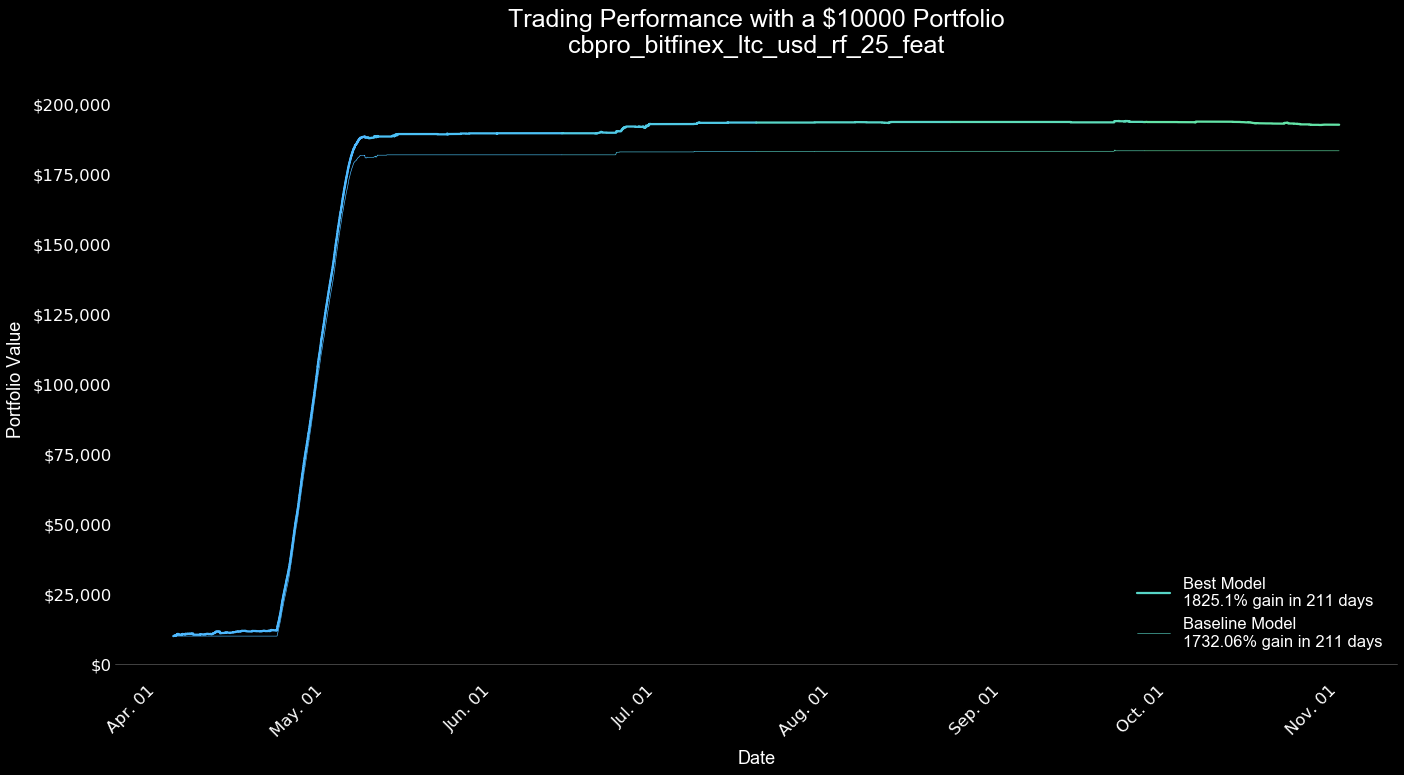

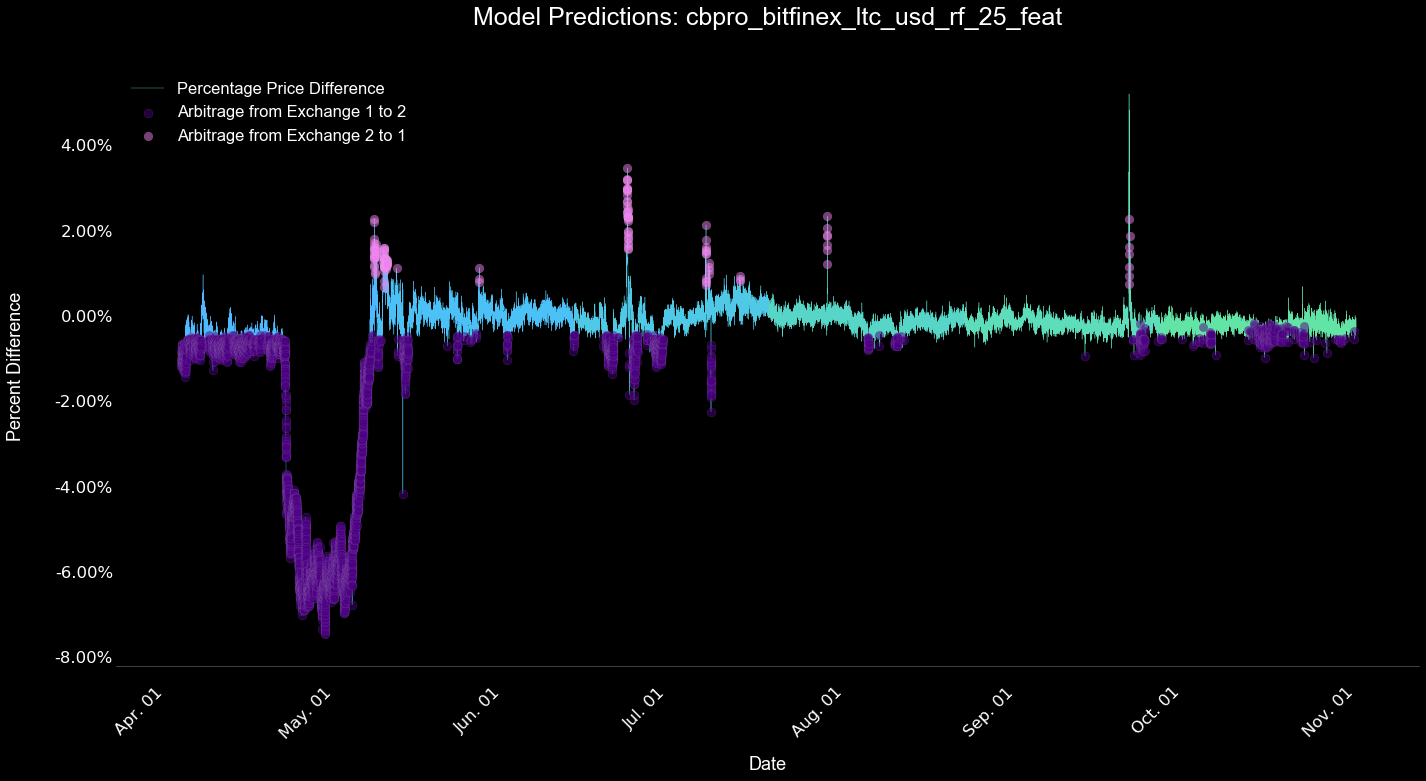

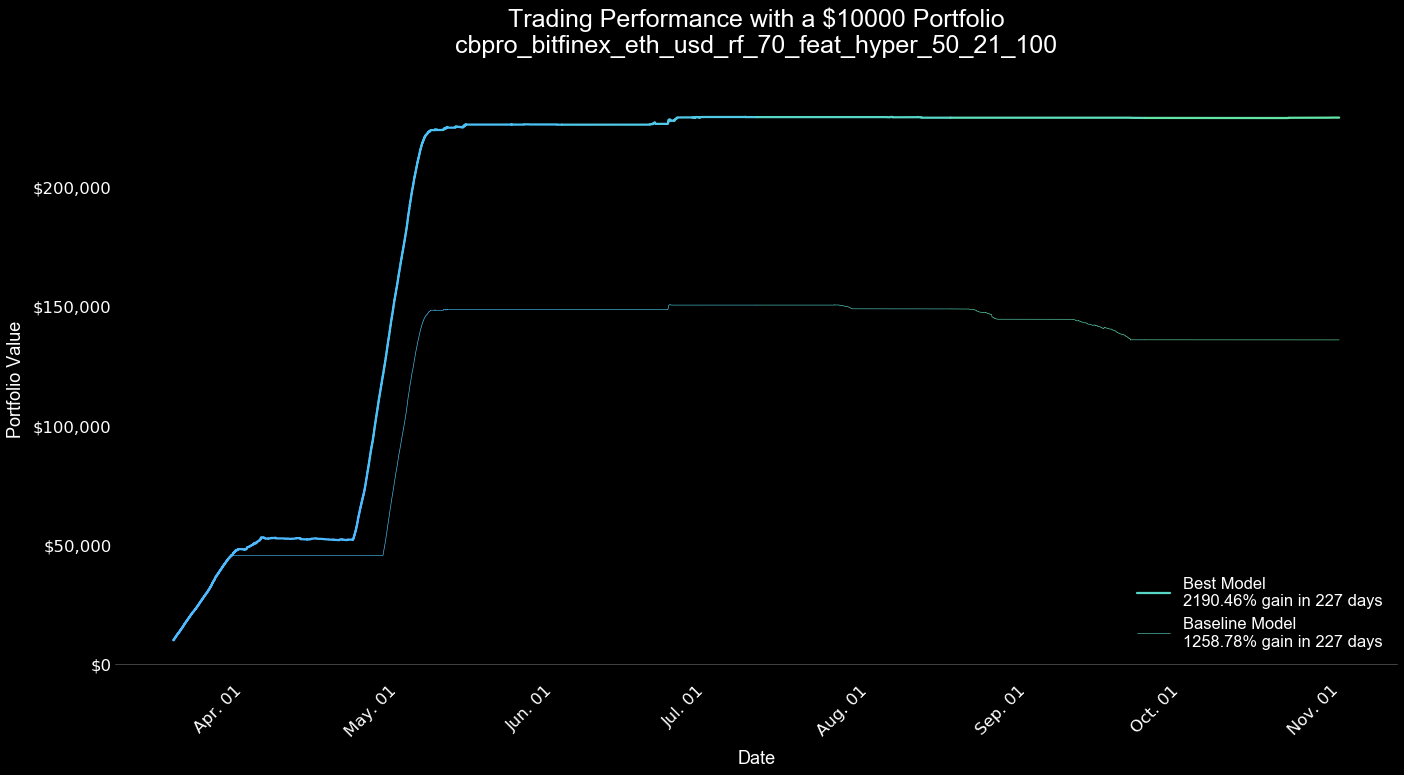

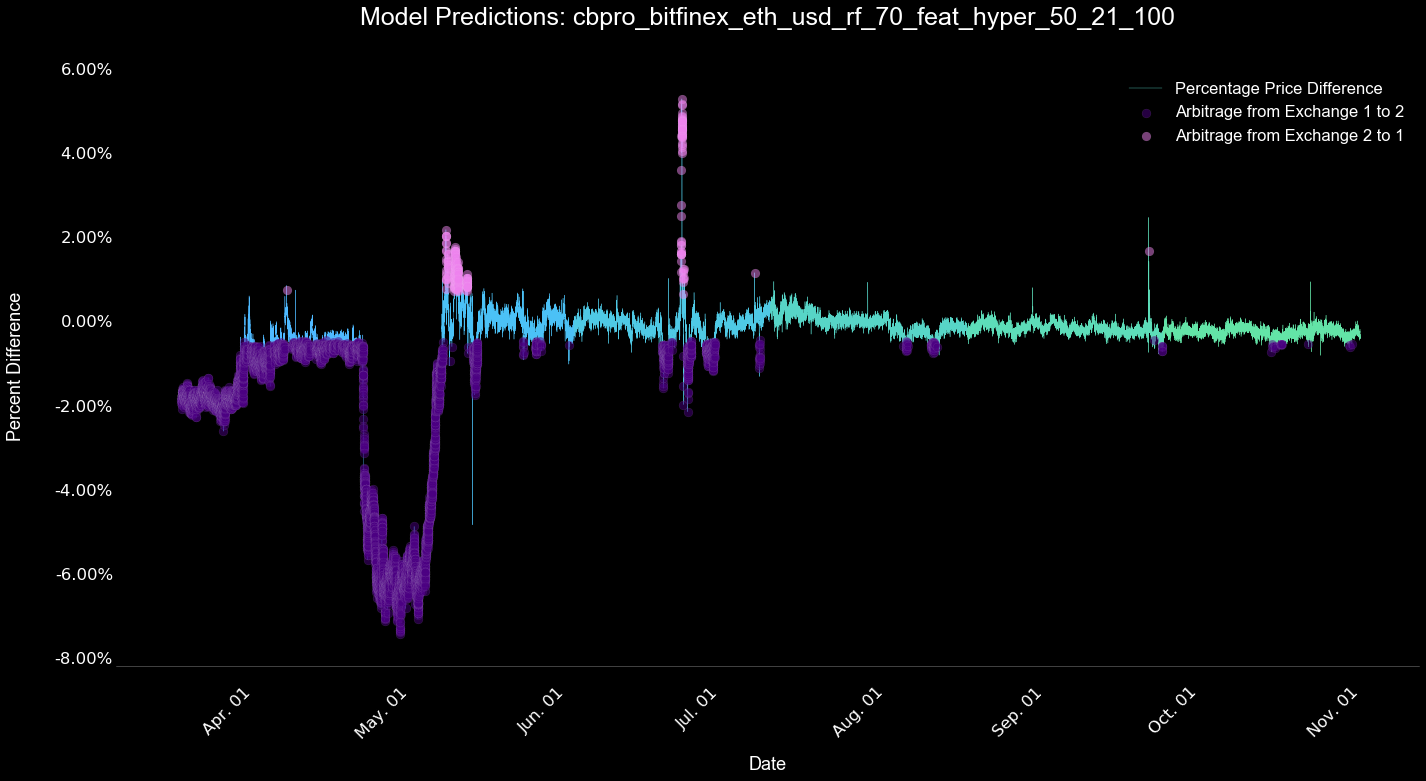

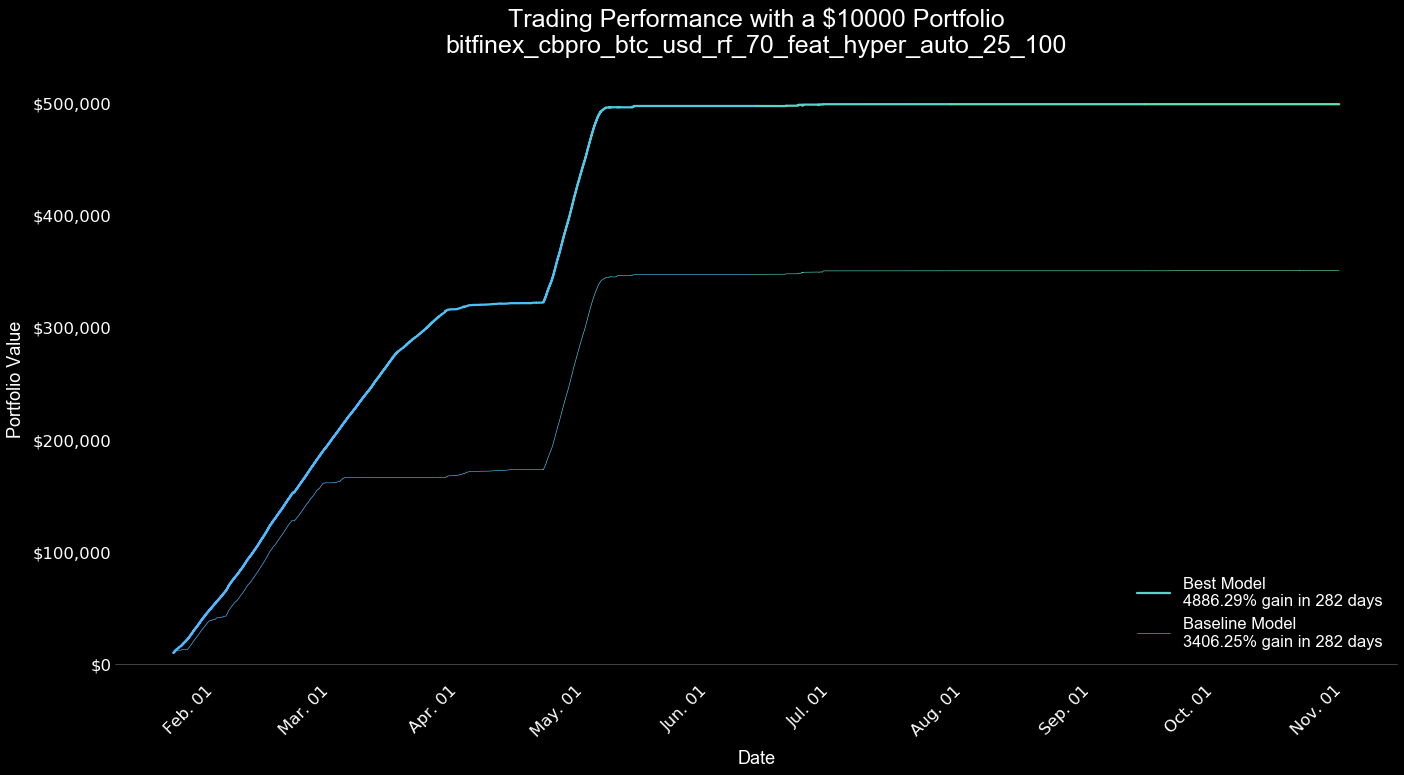

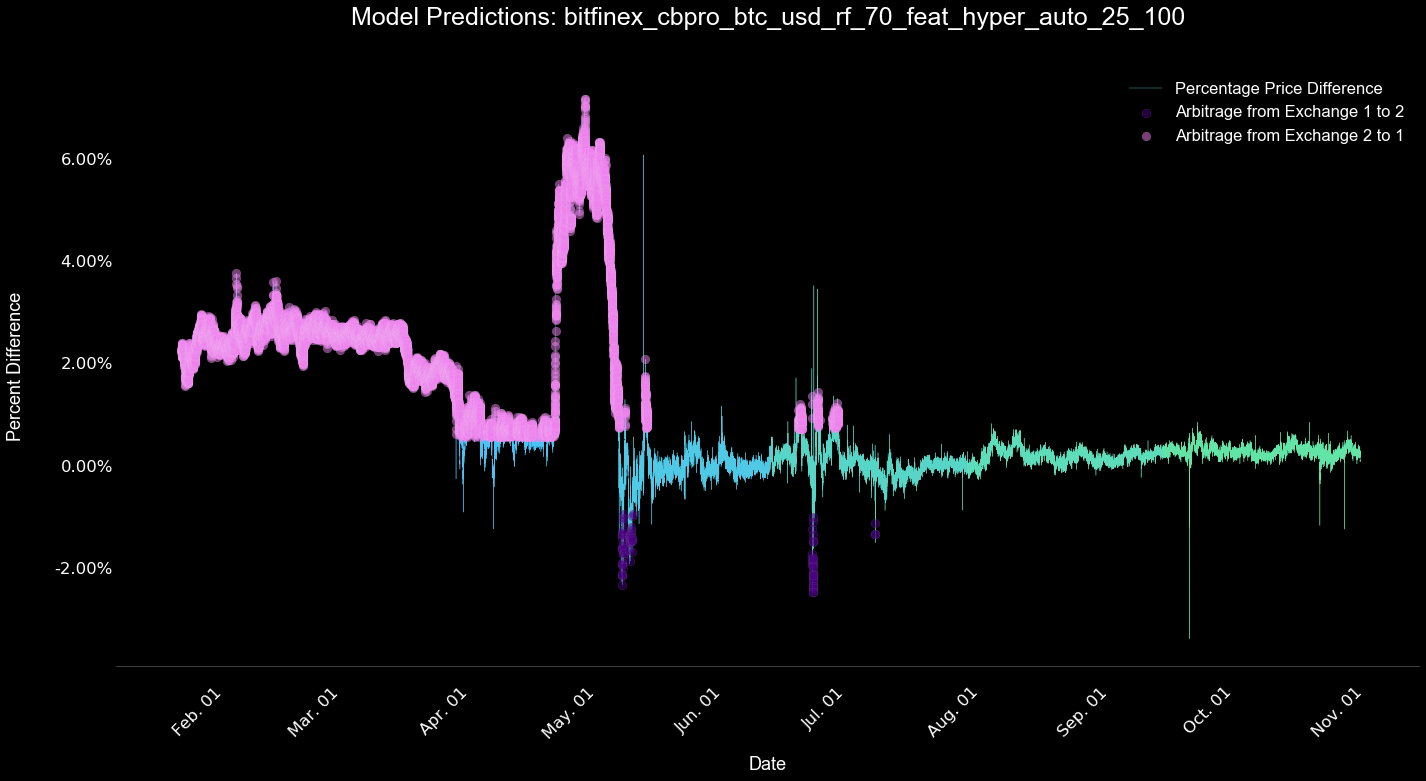

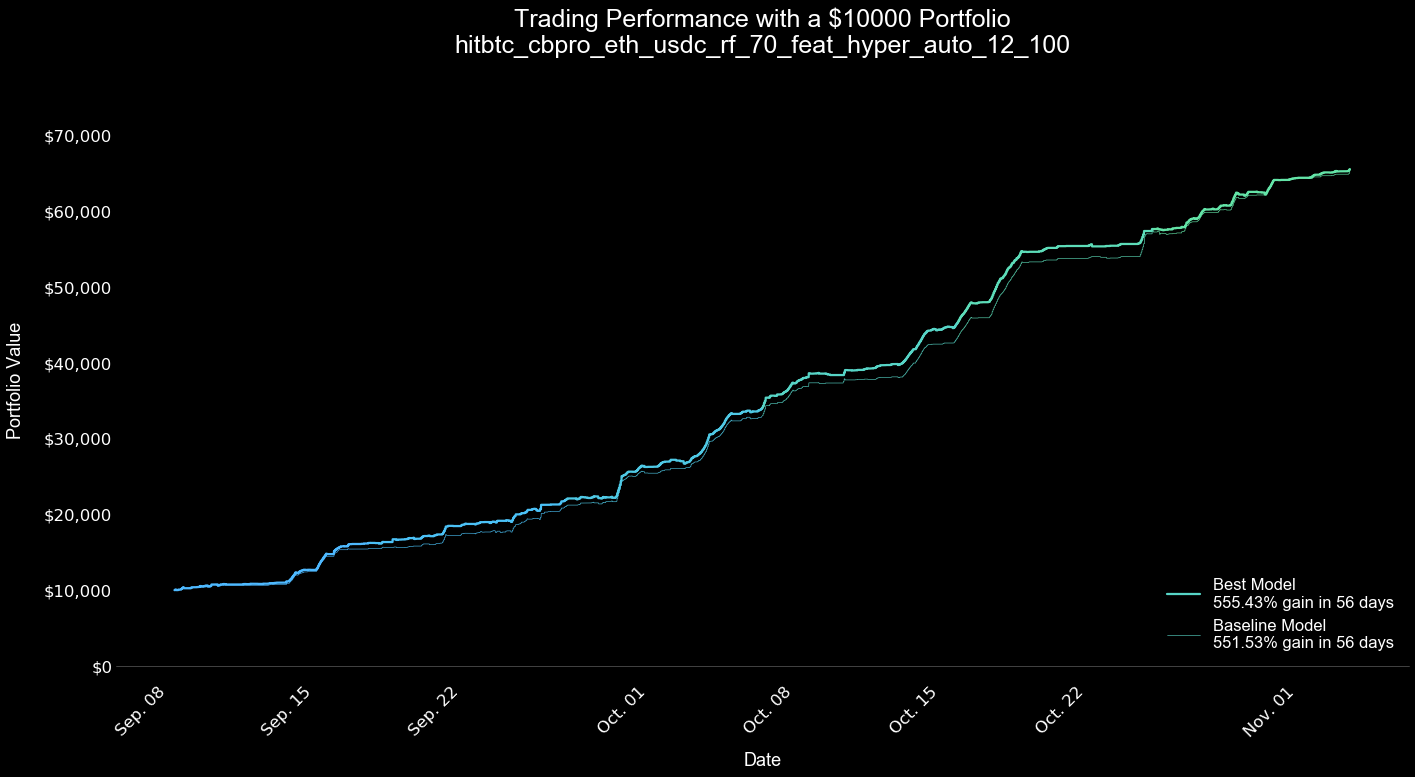

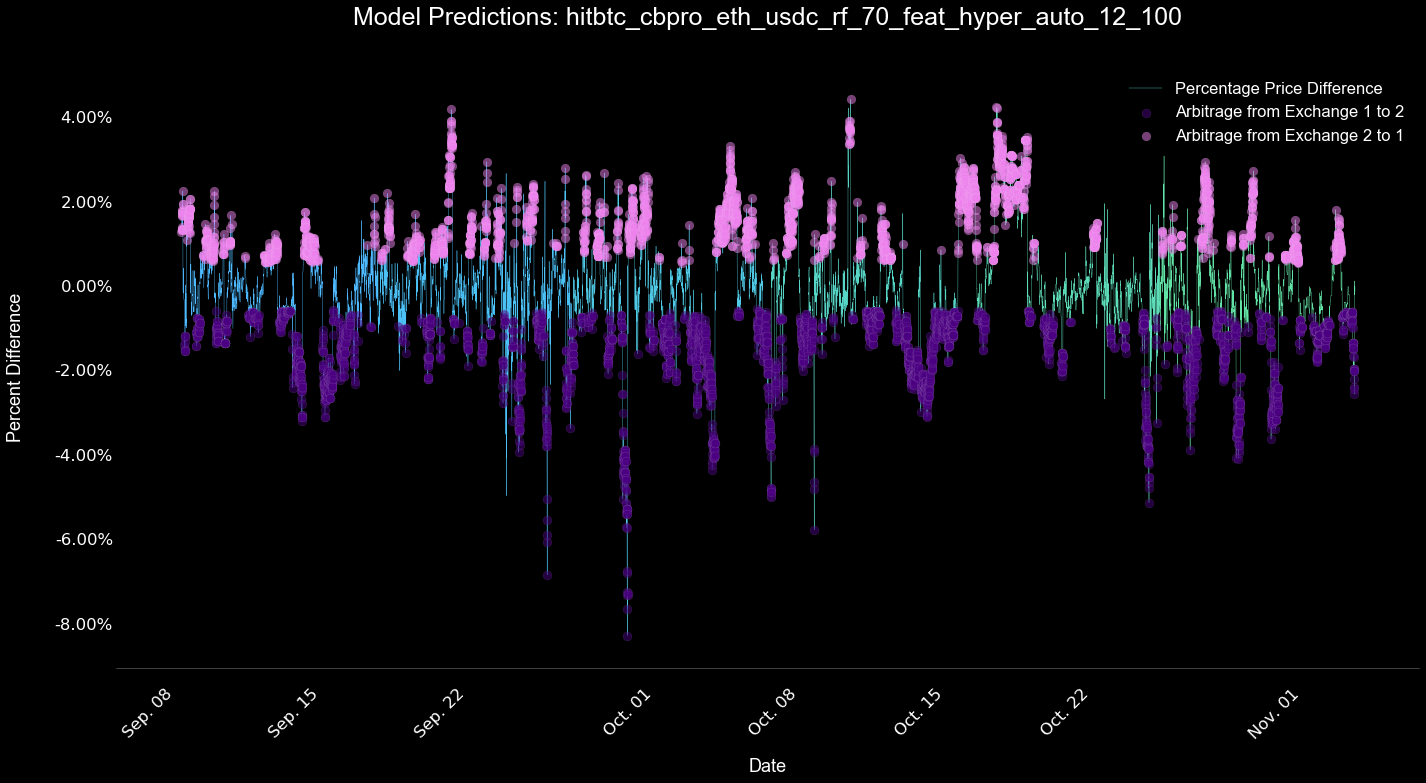

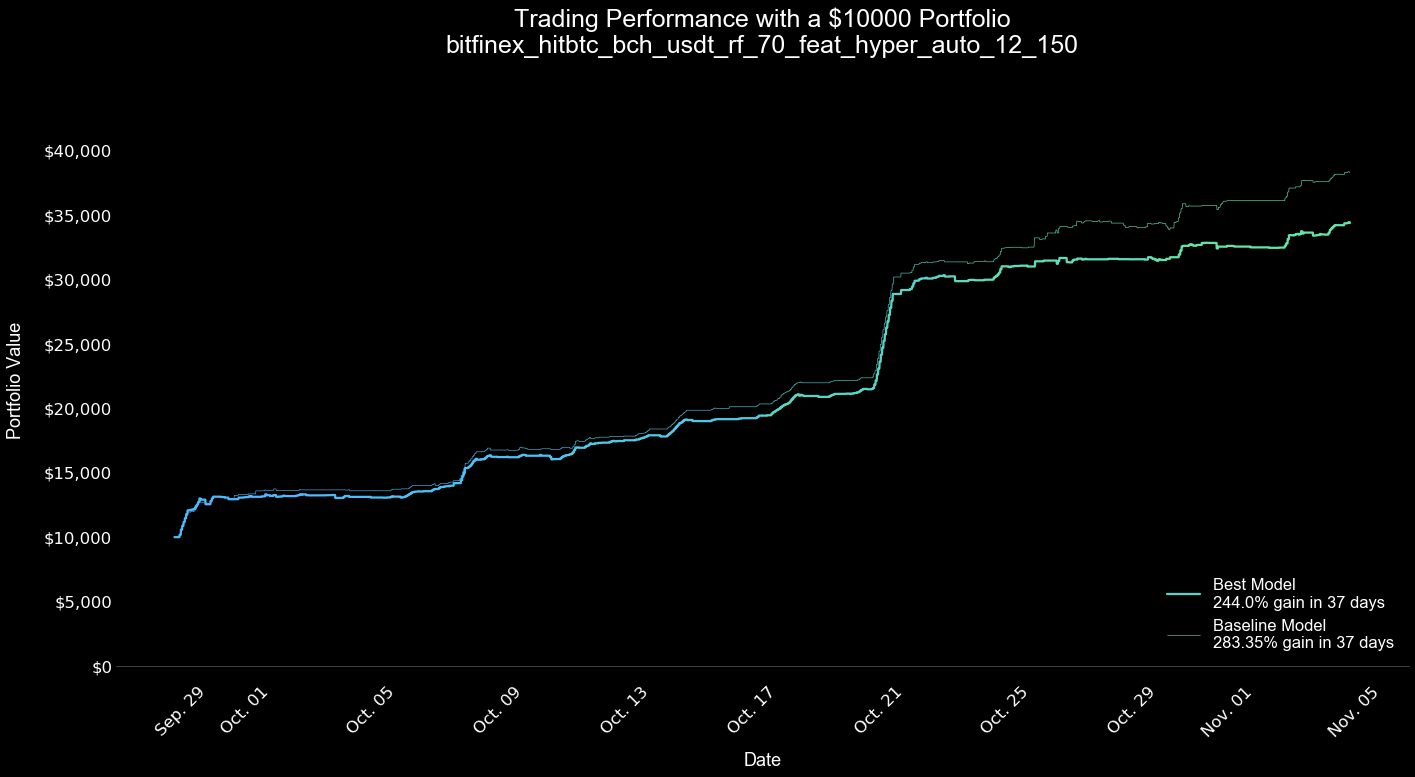

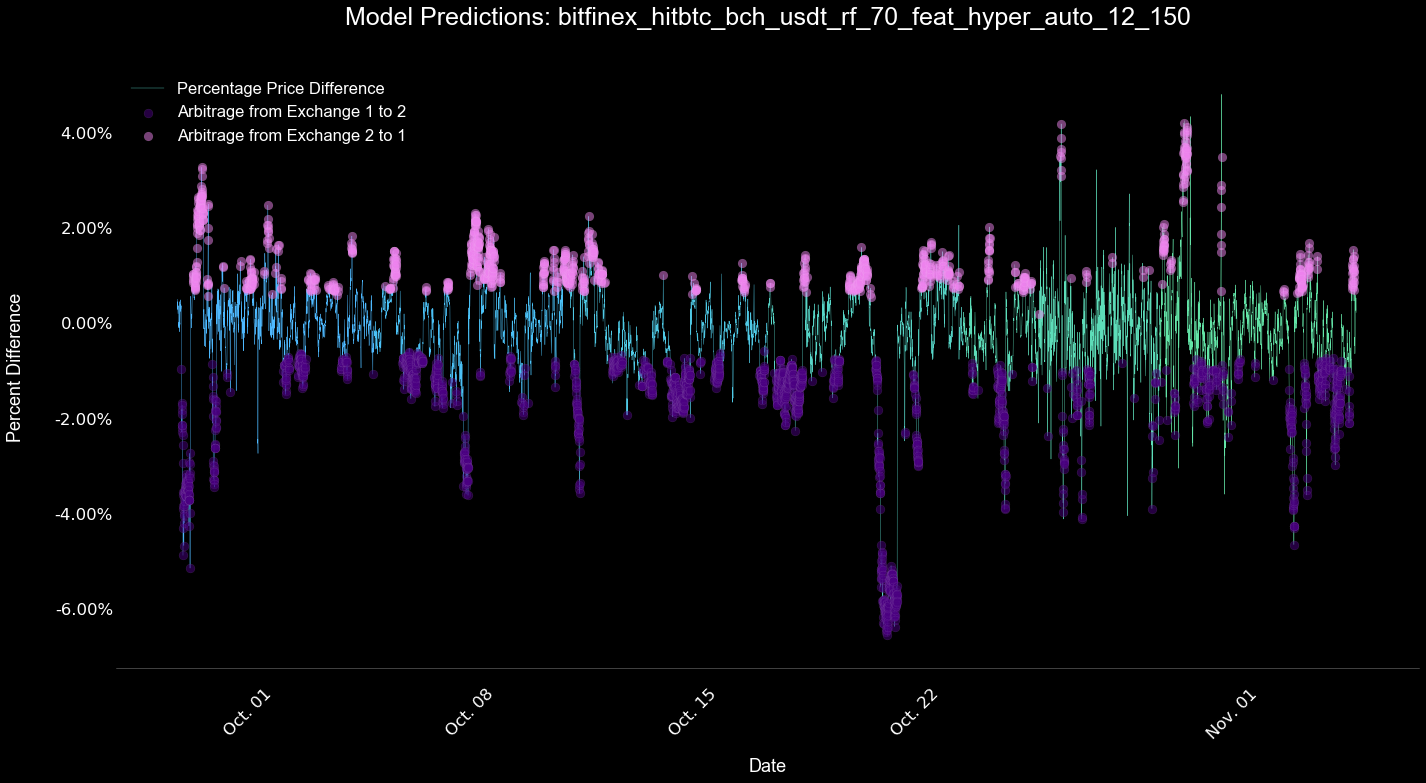

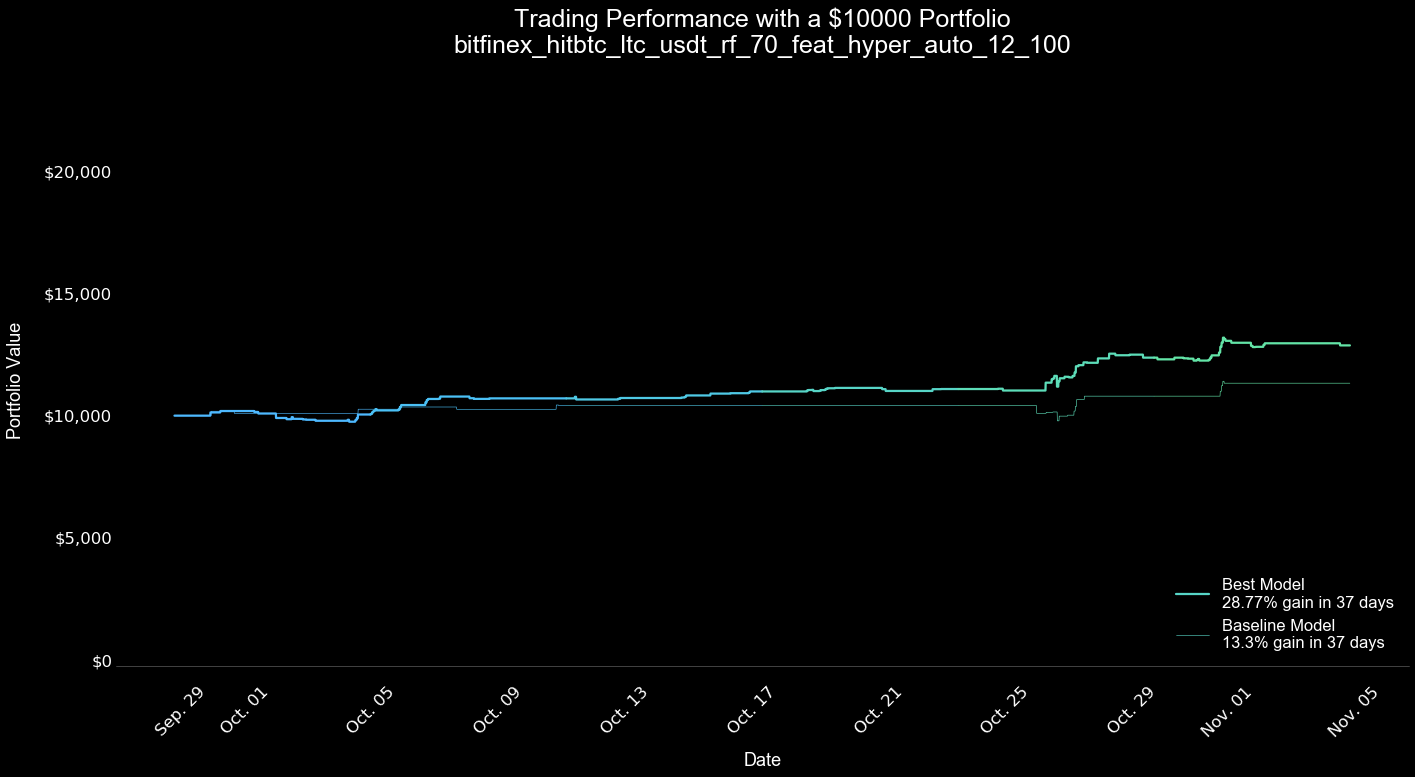

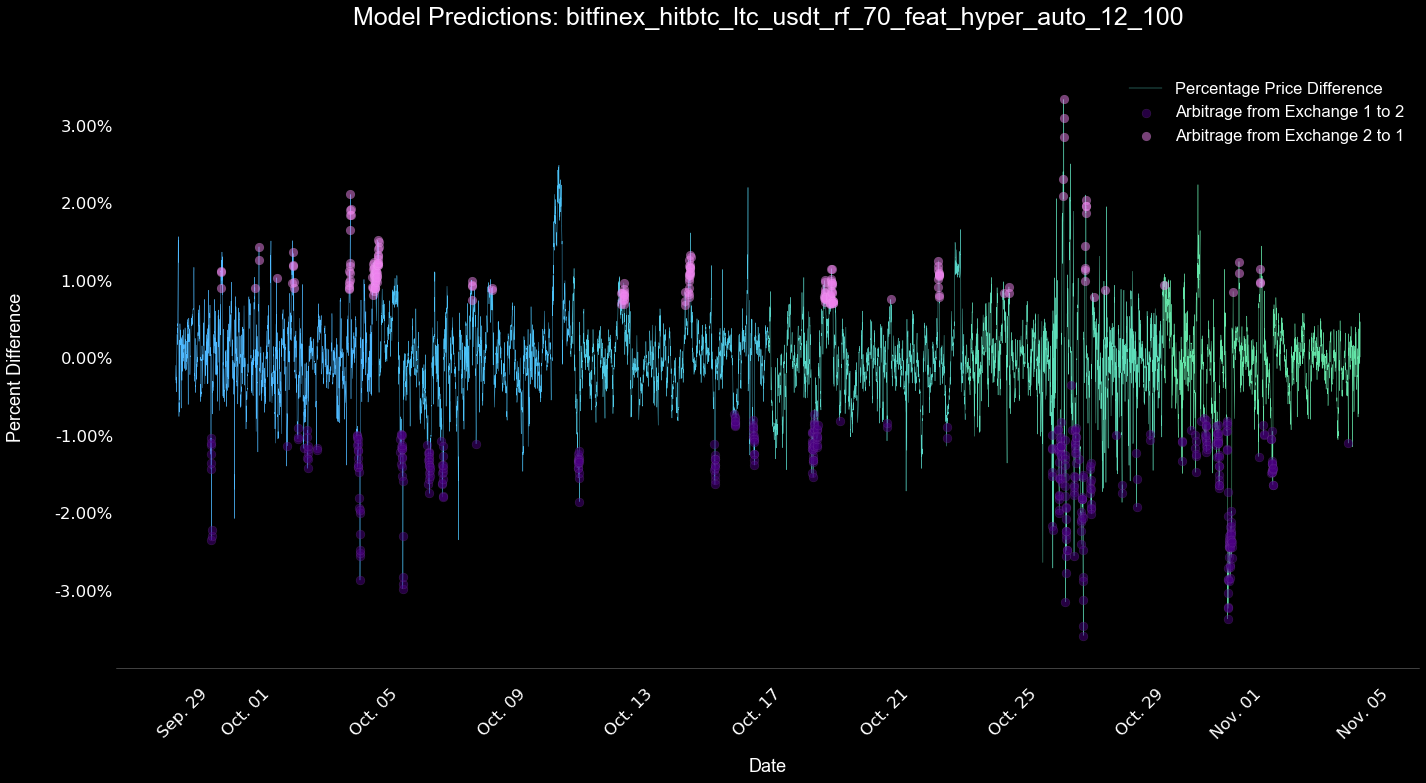

In [20]:
create_all_viz(top_models_df)